# Monash Solar Energy

## Importing libraries

In [58]:
import pandas as pd
import numpy as np

tsv_file='phase_1_data.tsf'
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('phase_1_data.csv',index=False)

In [59]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd


# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


# Example of usage
# loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

# print(loaded_data)
# print(frequency)
# print(forecast_horizon)
# print(contain_missing_values)
# print(contain_equal_length)

## Exacting head of data

In [3]:
loaded_data,frequency,forecast_horizon,contain_missing_values,contain_equal_length=convert_tsf_to_dataframe('phase_1_data.tsf',replace_missing_vals_with="NaN",value_column_name="series_value")
loaded_data

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,"[283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606..."
1,Building1,2019-01-09 23:15:00,"[8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,..."
2,Building3,2016-03-01 04:15:00,"[1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293...."
3,Building4,2019-07-03 04:45:00,"[2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ..."
4,Building5,2019-07-25 23:00:00,"[30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33...."
5,Building6,2019-07-25 01:45:00,"[36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35...."
6,Solar0,2020-04-25 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Solar1,2018-12-31 13:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Solar2,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Solar3,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
# Going through each row to create a new dataframe and manipulating it
df_building0 = pd.DataFrame(pd.date_range(start = '2016-07-03 21:30:00', freq='15T', periods=len(loaded_data.iloc[0, 2])))
df_building0.columns = ['Datetime']
df_building0['Building0'] = loaded_data.iloc[0, 2]
df_building0 = df_building0.set_index('Datetime')

df_building1 = pd.DataFrame(pd.date_range(start = '2019-01-09 23:15:00', freq='15T', periods=len(loaded_data.iloc[1, 2])))
df_building1.columns = ['Datetime']
df_building1['Building1'] = loaded_data.iloc[1, 2]
df_building1 = df_building1.set_index('Datetime')

df_building3 = pd.DataFrame(pd.date_range(start = '2016-03-01 04:15:00', freq='15T', periods=len(loaded_data.iloc[2, 2])))
df_building3.columns = ['Datetime']
df_building3['Building3'] = loaded_data.iloc[2, 2]
df_building3 = df_building3.set_index('Datetime')

df_building4 = pd.DataFrame(pd.date_range(start = '2019-07-03 04:45:00', freq='15T', periods=len(loaded_data.iloc[3, 2])))
df_building4.columns = ['Datetime']
df_building4['Building4'] = loaded_data.iloc[3, 2]
df_building4 = df_building4.set_index('Datetime')

df_building5 = pd.DataFrame(pd.date_range(start = '2019-07-25 23:00:00', freq='15T', periods=len(loaded_data.iloc[4, 2])))
df_building5.columns = ['Datetime']
df_building5['Building5'] = loaded_data.iloc[4, 2]
df_building5 = df_building5.set_index('Datetime')

df_building6 = pd.DataFrame(pd.date_range(start = '2019-07-25 01:45:00', freq='15T', periods=len(loaded_data.iloc[5, 2])))
df_building6.columns = ['Datetime']
df_building6['Building6'] = loaded_data.iloc[5, 2]
df_building6 = df_building6.set_index('Datetime')

df_solar0 = pd.DataFrame(pd.date_range(start = '2020-04-25 14:00:00', freq='15T', periods=len(loaded_data.iloc[6, 2])))
df_solar0.columns = ['Datetime']
df_solar0['solar0'] = loaded_data.iloc[6, 2]
df_solar0 = df_solar0.set_index('Datetime')

df_solar1 = pd.DataFrame(pd.date_range(start = '2018-12-31 13:00:00', freq='15T', periods=len(loaded_data.iloc[7, 2])))
df_solar1.columns = ['Datetime']
df_solar1['solar1'] = loaded_data.iloc[7, 2]
df_solar1 = df_solar1.set_index('Datetime')

df_solar2 = pd.DataFrame(pd.date_range(start = '2019-06-05 14:00:00', freq='15T', periods=len(loaded_data.iloc[8, 2])))
df_solar2.columns = ['Datetime']
df_solar2['solar2'] = loaded_data.iloc[8, 2]
df_solar2 = df_solar2.set_index('Datetime')

df_solar3 = pd.DataFrame(pd.date_range(start = '2019-06-05 14:00:00', freq='15T', periods=len(loaded_data.iloc[9, 2])))
df_solar3.columns = ['Datetime']
df_solar3['solar3'] = loaded_data.iloc[9, 2]
df_solar3 = df_solar3.set_index('Datetime')

df_solar4 = pd.DataFrame(pd.date_range(start = '2019-06-05 14:00:00', freq='15T', periods=len(loaded_data.iloc[10, 2])))
df_solar4.columns = ['Datetime']
df_solar4['solar4'] = loaded_data.iloc[10, 2]
df_solar4 = df_solar4.set_index('Datetime')

df_solar5 = pd.DataFrame(pd.date_range(start = '2019-01-15 13:00:00', freq='15T', periods=len(loaded_data.iloc[11, 2])))
df_solar5.columns = ['Datetime']
df_solar5['solar5'] = loaded_data.iloc[11, 2]
df_solar5 = df_solar5.set_index('Datetime')

In [5]:
df_1 = pd.merge(df_building0, df_building1, left_index=True, right_index=True, how='outer')
df_2 = pd.merge(df_1, df_building3, left_index=True, right_index=True, how='outer')
df_3 = pd.merge(df_2, df_building4, left_index=True, right_index=True, how='outer')
df_4 = pd.merge(df_3, df_building5, left_index=True, right_index=True, how='outer')
df_5 = pd.merge(df_4, df_building6, left_index=True, right_index=True, how='outer')
df_6 = pd.merge(df_5, df_solar0, left_index=True, right_index=True, how='outer')
df_7 = pd.merge(df_6, df_solar1, left_index=True, right_index=True, how='outer')
df_8 = pd.merge(df_7, df_solar2, left_index=True, right_index=True, how='outer')
df_9 = pd.merge(df_8, df_solar3, left_index=True, right_index=True, how='outer')
df_10 = pd.merge(df_9, df_solar4, left_index=True, right_index=True, how='outer')
finished_data = pd.merge(df_10, df_solar5, left_index=True, right_index=True, how='outer')
finished_data

,Building0,Building1,Building3,Building4,Building5,Building6,solar0,solar1,solar2,solar3,solar4,solar5
Datetime,,,,,,,,,,,,
2016-03-01 04:15:00,NaN,NaN,1321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 04:30:00,NaN,NaN,1321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 04:45:00,NaN,NaN,1321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 05:00:00,NaN,NaN,1321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 05:15:00,NaN,NaN,1293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,96.9,14.4,389,NaN,NaN,35.6,29.67,6.68,6.34,5.49,4.55,25.28
2020-09-30 23:00:00,96.9,18.8,389,1,NaN,38.6,29.94,6.71,6.39,5.65,4.57,25.30
2020-09-30 23:15:00,37.4,4.5,415,NaN,NaN,38.6,34.02,8.13,7.71,6.83,5.32,28.62


In [6]:
new_fin = finished_data.reset_index()
new = new_fin.resample('1H', on = 'Datetime').mean()
new

,solar0,solar1,solar2,solar3,solar4,solar5
Datetime,,,,,,
2016-03-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-09-30 19:00:00,0.1100,0.0325,0.0250,0.0200,0.0175,0.0975
2020-09-30 20:00:00,3.0325,0.6775,0.6500,0.4675,0.4875,2.4375
2020-09-30 21:00:00,14.6625,3.0950,3.0025,2.2125,2.3750,12.3675


In [7]:
Whether_data=pd.read_csv('ERA5_Weather_Data_Monash.csv')
nw = Whether_data[54028:94225]

nw['Date'] = pd.to_datetime(nw['datetime (UTC)'])
nw.set_index('Date', inplace=True)
weatherdata = nw.resample('15T').asfreq()
weather_data = weatherdata.interpolate()
weather_data

<ipython-input-7-ae5c1f25ed19>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nw['Date'] = pd.to_datetime(nw['datetime (UTC)'])


,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
Date,,,,,,,,,,,,,
2016-03-01 04:00:00,2016-03-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,30.730,11.4900,3.8300,101461.2600,0.310,884.1500,358.8400,0.9700
2016-03-01 04:15:00,NaN,NaN,NaN,69.59,10.0,30.795,11.2975,3.6375,101441.4375,0.305,856.8575,360.3900,0.9675
2016-03-01 04:30:00,NaN,NaN,NaN,69.59,10.0,30.860,11.1050,3.4450,101421.6150,0.300,829.5650,361.9400,0.9650
2016-03-01 04:45:00,NaN,NaN,NaN,69.59,10.0,30.925,10.9125,3.2525,101401.7925,0.295,802.2725,363.4900,0.9625
2016-03-01 05:00:00,2016-03-01 05:00:00,"(-37.91, 145.13)",era5,69.59,10.0,30.990,10.7200,3.0600,101381.9700,0.290,774.9800,365.0400,0.9600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 23:00:00,2020-09-30 23:00:00,"(-37.91, 145.13)",era5,69.59,10.0,12.060,6.8000,5.1000,101692.5000,0.700,406.3800,282.6900,0.3500
2020-09-30 23:15:00,NaN,NaN,NaN,69.59,10.0,12.275,6.6775,5.0475,101699.9525,0.685,444.8525,282.1825,0.3825
2020-09-30 23:30:00,NaN,NaN,NaN,69.59,10.0,12.490,6.5550,4.9950,101707.4050,0.670,483.3250,281.6750,0.4150


In [47]:
final = pd.merge(weather_data, finished_data, left_index=True, right_index=True, how='outer')
final = final.drop(['datetime (UTC)', 'coordinates (lat,lon)', 'model (name)', 'utc_offset (hrs)', 'model elevation (surface)'], axis=1)
final = final[123632:160784]

# Xf=final[['solar0','solar1','solar2','solar3','solar4','solar5']]

# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# final1 = final.copy()
# final1[final1==0] = np.nan
# # final1
# X = final1.iloc[:,14:]
# Xm = X.mean()
# Xs = X.std()
# X = (X-X.mean())/X.std()
# Xt = IterativeImputer(max_iter=100, random_state=0).fit_transform(X)
# final1.iloc[:,14:] = Xt
# final1.iloc[:,14:] = Xs*final1.iloc[:,14:]+Xm
final['hour']=final.index.strftime('%H')
final['day']=final.hour.apply(lambda x: 1 if x >= '07' and x<='18' else 0)
final
#123632

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),Building0,Building1,...,Building5,Building6,solar0,solar1,solar2,solar3,solar4,solar5,hour,day
2019-09-10 00:00:00,11.4200,7.6400,3.1900,102903.4700,0.7800,391.8400,313.0000,0.5100,NaN,29.3,...,23,34.6,NaN,0.00,0.00,0.00,0.00,0.00,00,0
2019-09-10 00:15:00,11.4675,7.5850,3.2275,102910.6875,0.7725,417.5325,311.8550,0.5625,NaN,7.7,...,45,34.6,NaN,0.00,0.00,0.00,0.00,0.00,00,0
2019-09-10 00:30:00,11.5150,7.5300,3.2650,102917.9050,0.7650,443.2250,310.7100,0.6150,NaN,15.8,...,23,31.6,NaN,0.00,0.00,0.00,0.00,0.00,00,0
2019-09-10 00:45:00,11.5625,7.4750,3.3025,102925.1225,0.7575,468.9175,309.5650,0.6675,NaN,23.4,...,22,31.6,NaN,0.00,0.00,0.00,0.00,0.00,00,0
2019-09-10 01:00:00,11.6100,7.4200,3.3400,102932.3400,0.7500,494.6100,308.4200,0.7200,NaN,30.6,...,44,32.8,NaN,0.00,0.00,0.00,0.00,0.00,01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,11.8025,6.8275,5.0100,101674.3875,0.7150,367.3475,282.5450,0.3100,96.9,14.4,...,NaN,35.6,29.67,6.68,6.34,5.49,4.55,25.28,22,0
2020-09-30 23:00:00,12.0600,6.8000,5.1000,101692.5000,0.7000,406.3800,282.6900,0.3500,96.9,18.8,...,NaN,38.6,29.94,6.71,6.39,5.65,4.57,25.30,23,0
2020-09-30 23:15:00,12.2750,6.6775,5.0475,101699.9525,0.6850,444.8525,282.1825,0.3825,37.4,4.5,...,NaN,38.6,34.02,8.13,7.71,6.83,5.32,28.62,23,0
2020-09-30 23:30:00,12.4900,6.5550,4.9950,101707.4050,0.6700,483.3250,281.6750,0.4150,37.4,9.6,...,NaN,38.6,38.10,9.55,9.03,8.02,6.08,31.94,23,0


In [9]:
solar4 = final.drop(['Building0','Building1','Building3','Building5','Building6','solar0','solar1','solar2','solar3','solar5'], axis=1)
solar4 = solar4[solar4['solar4'].map(solar4['solar4'].value_counts()).le(97)]
solar4

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),Building4,solar4,hour,day
2019-09-16 05:15:00,10.4000,2.4475,5.8250,102242.9800,0.5800,506.6650,283.7475,0.8950,NaN,0.17,05,0
2019-09-16 05:30:00,10.2100,2.2550,5.7800,102251.7000,0.5800,471.2800,282.3650,0.8500,1,0.35,05,0
2019-09-16 05:45:00,10.0200,2.0625,5.7350,102260.4200,0.5800,435.8950,280.9825,0.8050,1,1.58,05,0
2019-09-16 06:00:00,9.8300,1.8700,5.6900,102269.1400,0.5800,400.5100,279.6000,0.7600,1,2.81,06,0
2019-09-16 06:15:00,9.7900,1.8950,5.6325,102283.3000,0.5825,359.9275,278.5875,0.6750,1,2.25,06,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,11.8025,6.8275,5.0100,101674.3875,0.7150,367.3475,282.5450,0.3100,NaN,4.55,22,0
2020-09-30 23:00:00,12.0600,6.8000,5.1000,101692.5000,0.7000,406.3800,282.6900,0.3500,1,4.57,23,0
2020-09-30 23:15:00,12.2750,6.6775,5.0475,101699.9525,0.6850,444.8525,282.1825,0.3825,NaN,5.32,23,0
2020-09-30 23:30:00,12.4900,6.5550,4.9950,101707.4050,0.6700,483.3250,281.6750,0.4150,NaN,6.08,23,0


From observing the graph above, it can be seen that when there is cloud cover, the solar production becomes inconsistent.
Solar Panels follow the same trend which is expected, have different values which may be due to angle, position and efficency of panel.

In [13]:
final.reset_index(inplace=True)

In [14]:
def missing_val(data):
    removes=[]
    for sol in ['solar4']: #['solar0','solar1','solar2','solar3','solar4','solar5']:
        sol_df = data[sol]
        i=0
        while i < len(data):
            
            val = sol_df.iloc[i]
            if val<=0.5 or pd.isna(val):
                removes.append(i)
                
            i+=1
            
        data.drop(removes, axis=0, inplace=True)
            
        
missing_val(final)

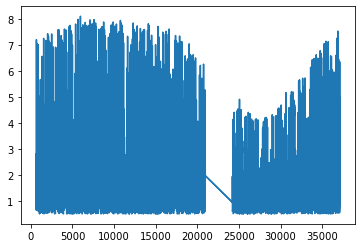

In [15]:
import matplotlib.pyplot as plt
plt.plot(final.index, final['solar4']);

In [86]:
features = final.drop(['Building0', 'Building1','Building3','Building4','Building5','Building6','solar0','solar1','solar2','solar3','solar4','solar5'], axis=1)
label = final['solar4']

<AxesSubplot:ylabel='Feature_Name'>

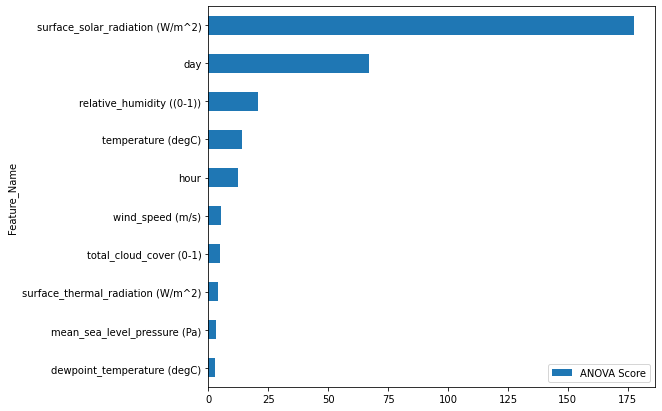

In [87]:
from sklearn.feature_selection import SelectKBest
features_new = SelectKBest(k='all').fit(features, label)
df_scores = pd.DataFrame(features_new.scores_)
df_columns = pd.DataFrame(features.columns)
# concatenate dataframes
anova_scores = pd.concat([df_columns, df_scores],axis=1)
anova_scores.columns = ['Feature_Name','ANOVA Score']  # name output columns

anova_scores.set_index('Feature_Name', inplace=True)
anova_scores.sort_values(by='ANOVA Score').plot(kind='barh', figsize=(8, 7))

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def num_var_used():
    scores = []
    for i in range(1,10): 
        features_anova = SelectKBest(k=i).fit_transform(features, label)
        X_train, X_test, y_train, y_test = train_test_split(features_anova, label, test_size=0.2)
        linear = LinearRegression()
        linear.fit(X_train,y_train)
        y_pred = linear.predict(X_test)
        R2 = r2_score(y_test, y_pred)
        scores.append(1-(1-R2)*(len(X_train)-1)/(len(X_train)-i-1))
    print(scores)

num_var_used()

[0.6601997682575987, 0.6385008007884423, 0.6560957293673924, 0.6611246659235066, 0.6820310364678792, 0.680060365756177, 0.6824282705614992, 0.6755094740155958, 0.6783626609287738]


In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def num_var_used():
    scores = [] # array of all acuracies using k-best features
    for i in range(1,10): # looping through each number of k best features
        features_anova = SelectKBest(k=i).fit_transform(features, label)
        X_train, X_test, y_train, y_test = train_test_split(features_anova, label, test_size=0.2)
        rfr = RandomForestRegressor(n_estimators=100)
        rfr.fit(X_train,y_train)
        y_pred = rfr.predict(X_test)
        R2 = r2_score(y_test, y_pred) # calculating the R^2 value
        scores.append(round(1-(1-R2)*(len(X_train)-1)/(len(X_train)-i-1),3)) # adding adjusted R^2 value to scores
    print(scores)

num_var_used()

[0.645, 0.685, 0.761, 0.803, 0.869, 0.9, 0.923, 0.933, 0.942]


In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.8)
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(len(X_train))

3836


In [25]:
solar4

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),Building4,solar4,hour,day
2019-09-16 05:15:00,10.4000,2.4475,5.8250,102242.9800,0.5800,506.6650,283.7475,0.8950,NaN,0.17,05,0
2019-09-16 05:30:00,10.2100,2.2550,5.7800,102251.7000,0.5800,471.2800,282.3650,0.8500,1,0.35,05,0
2019-09-16 05:45:00,10.0200,2.0625,5.7350,102260.4200,0.5800,435.8950,280.9825,0.8050,1,1.58,05,0
2019-09-16 06:00:00,9.8300,1.8700,5.6900,102269.1400,0.5800,400.5100,279.6000,0.7600,1,2.81,06,0
2019-09-16 06:15:00,9.7900,1.8950,5.6325,102283.3000,0.5825,359.9275,278.5875,0.6750,1,2.25,06,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,11.8025,6.8275,5.0100,101674.3875,0.7150,367.3475,282.5450,0.3100,NaN,4.55,22,0
2020-09-30 23:00:00,12.0600,6.8000,5.1000,101692.5000,0.7000,406.3800,282.6900,0.3500,1,4.57,23,0
2020-09-30 23:15:00,12.2750,6.6775,5.0475,101699.9525,0.6850,444.8525,282.1825,0.3825,NaN,5.32,23,0
2020-09-30 23:30:00,12.4900,6.5550,4.9950,101707.4050,0.6700,483.3250,281.6750,0.4150,NaN,6.08,23,0


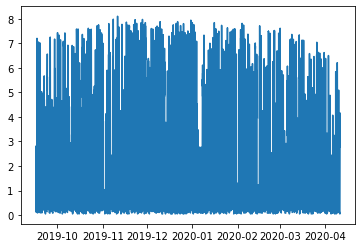

In [26]:
temp=solar4[:10500] #13950
plt.plot(temp.index, temp['solar4']);

In [27]:
temp

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),Building4,solar4,hour,day
2019-09-16 05:15:00,10.4000,2.4475,5.8250,102242.9800,0.5800,506.6650,283.7475,0.8950,NaN,0.17,05,0
2019-09-16 05:30:00,10.2100,2.2550,5.7800,102251.7000,0.5800,471.2800,282.3650,0.8500,1,0.35,05,0
2019-09-16 05:45:00,10.0200,2.0625,5.7350,102260.4200,0.5800,435.8950,280.9825,0.8050,1,1.58,05,0
2019-09-16 06:00:00,9.8300,1.8700,5.6900,102269.1400,0.5800,400.5100,279.6000,0.7600,1,2.81,06,0
2019-09-16 06:15:00,9.7900,1.8950,5.6325,102283.3000,0.5825,359.9275,278.5875,0.6750,1,2.25,06,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-11 00:15:00,13.3525,7.9500,9.6350,100637.2500,0.6975,374.9025,308.4525,0.3975,NaN,3.46,00,0
2020-04-11 00:30:00,13.4550,7.5200,9.8900,100651.7100,0.6750,405.7650,310.0350,0.3850,1,2.77,00,0
2020-04-11 00:45:00,13.5575,7.0900,10.1450,100666.1700,0.6525,436.6275,311.6175,0.3725,NaN,2.77,00,0
2020-04-11 01:00:00,13.6600,6.6600,10.4000,100680.6300,0.6300,467.4900,313.2000,0.3600,1,2.77,01,0


In [28]:
features = temp.drop(['Building4','solar4'], axis=1)
label = temp['solar4']

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def num_var_used():
    scores = []
    for i in range(1,10):
        features_anova = SelectKBest(k=i).fit_transform(features, label)
        X_train, X_test, y_train, y_test = train_test_split(features_anova, label, test_size=0.2)
        rfr = RandomForestRegressor(n_estimators=100)
        rfr.fit(X_train,y_train)
        y_pred = rfr.predict(X_test)
        R2 = r2_score(y_test, y_pred)
        scores.append(1-(1-R2)*(len(X_train)-1)/(len(X_train)-i-1))
    print(scores)

num_var_used()

[0.48102171372253666, 0.5611775904890426, 0.6910988466399913, 0.7711056348394353, 0.8459415703099022, 0.8940680116670936, 0.900779273956097, 0.9127188703053858, 0.9236136655103496]


In [30]:
temp2=solar4[13950:] #13950
features = temp2.drop(['Building4','solar4'], axis=1)
label = temp2['solar4']

def num_var_used():
    scores = []
    for i in range(1,10):
        features_anova = SelectKBest(k=i).fit_transform(features, label)
        X_train, X_test, y_train, y_test = train_test_split(features_anova, label, test_size=0.2)
        rfr = RandomForestRegressor(n_estimators=100)
        rfr.fit(X_train,y_train)
        y_pred = rfr.predict(X_test)
        R2 = r2_score(y_test, y_pred)
        scores.append(1-(1-R2)*(len(X_train)-1)/(len(X_train)-i-1))
    print(scores)

num_var_used()

[0.4546761793760864, 0.6099946261498769, 0.7453136810383503, 0.8071919142388322, 0.8699220192027317, 0.8800145679150941, 0.8863744917349012, 0.8710347549020717, 0.8952529841588283]


In [31]:
test_w=Whether_data

test_w['Date'] = pd.to_datetime(Whether_data['datetime (UTC)'])
test_w.set_index('Date', inplace=True)
test_w = test_w.resample('15T').asfreq()
test_w = test_w.interpolate()
test_w = test_w.drop(['datetime (UTC)', 'coordinates (lat,lon)', 'model (name)', 'utc_offset (hrs)', 'model elevation (surface)'], axis=1)

test_w['index1'] = test_w.index
mask = (test_w['index1'] >= '2020-10-01 00:00:00') & (test_w['index1'] <= '2020-10-31 23:45:00') # month of October
test_w = test_w.loc[mask] 

test_w = test_w.drop('index1', axis=1)
test_w['hour'] = test_w.index.strftime('%H')
test_w['day'] = test_w.hour.apply(lambda x: 1 if x >= '07' and x<='18' else 0)
test_w

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),hour,day
Date,,,,,,,,,,
2020-10-01 00:00:00,12.9200,6.310,4.8900,101722.3100,0.640,560.270,280.6600,0.4800,00,0
2020-10-01 00:15:00,13.1575,6.185,4.9150,101719.2675,0.625,591.175,283.0625,0.5425,00,0
2020-10-01 00:30:00,13.3950,6.060,4.9400,101716.2250,0.610,622.080,285.4650,0.6050,00,0
2020-10-01 00:45:00,13.6325,5.935,4.9650,101713.1825,0.595,652.985,287.8675,0.6675,00,0
2020-10-01 01:00:00,13.8700,5.810,4.9900,101710.1400,0.580,683.890,290.2700,0.7300,01,0
...,...,...,...,...,...,...,...,...,...,...
2020-10-31 22:45:00,13.8375,9.130,2.6475,102377.6675,0.735,365.750,348.8950,0.9825,22,0
2020-10-31 23:00:00,13.9700,9.150,2.7100,102386.0800,0.730,394.750,353.9000,0.9800,23,0
2020-10-31 23:15:00,14.0875,9.195,2.7950,102389.2525,0.725,420.475,354.2725,0.9700,23,0


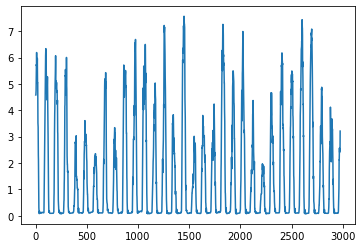

In [32]:
features = temp.drop(['Building4','solar4'], axis=1)
label = temp['solar4']

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2)
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train,y_train)
y_pred = rfr.predict(test_w)
plt.plot(y_pred)

In [33]:
final

,index,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),Building0,...,Building5,Building6,solar0,solar1,solar2,solar3,solar4,solar5,hour,day
599,2019-09-16 05:45:00,10.0200,2.0625,5.7350,102260.4200,0.5800,435.8950,280.9825,0.8050,NaN,...,20,37.4,NaN,0.00,1.64,0.07,1.58,0.00,05,0
600,2019-09-16 06:00:00,9.8300,1.8700,5.6900,102269.1400,0.5800,400.5100,279.6000,0.7600,NaN,...,40,36.6,NaN,0.00,1.31,0.08,2.81,0.00,06,0
601,2019-09-16 06:15:00,9.7900,1.8950,5.6325,102283.3000,0.5825,359.9275,278.5875,0.6750,NaN,...,20,36.6,NaN,0.00,0.98,0.08,2.25,0.00,06,0
602,2019-09-16 06:30:00,9.7500,1.9200,5.5750,102297.4600,0.5850,319.3450,277.5750,0.5900,NaN,...,40,37.6,NaN,0.00,0.66,0.08,1.68,0.00,06,0
603,2019-09-16 06:45:00,9.7100,1.9450,5.5175,102311.6200,0.5875,278.7625,276.5625,0.5050,NaN,...,20,37.6,NaN,0.00,0.99,0.09,1.19,0.00,06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37147,2020-09-30 22:45:00,11.8025,6.8275,5.0100,101674.3875,0.7150,367.3475,282.5450,0.3100,96.9,...,NaN,35.6,29.67,6.68,6.34,5.49,4.55,25.28,22,0
37148,2020-09-30 23:00:00,12.0600,6.8000,5.1000,101692.5000,0.7000,406.3800,282.6900,0.3500,96.9,...,NaN,38.6,29.94,6.71,6.39,5.65,4.57,25.30,23,0
37149,2020-09-30 23:15:00,12.2750,6.6775,5.0475,101699.9525,0.6850,444.8525,282.1825,0.3825,37.4,...,NaN,38.6,34.02,8.13,7.71,6.83,5.32,28.62,23,0
37150,2020-09-30 23:30:00,12.4900,6.5550,4.9950,101707.4050,0.6700,483.3250,281.6750,0.4150,37.4,...,NaN,38.6,38.10,9.55,9.03,8.02,6.08,31.94,23,0


## Solar model for all panels

In [60]:
final = pd.merge(weather_data, finished_data, left_index=True, right_index=True, how='outer')
final = final.drop(['datetime (UTC)', 'coordinates (lat,lon)', 'model (name)', 'utc_offset (hrs)', 'model elevation (surface)'], axis=1)
final = final[123632:160784]
final['hour']=final.index.strftime('%H')
final['day']=final.hour.apply(lambda x: 1 if x >= '07' and x<='18' else 0)
final

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),Building0,Building1,...,Building5,Building6,solar0,solar1,solar2,solar3,solar4,solar5,hour,day
2019-09-10 00:00:00,11.4200,7.6400,3.1900,102903.4700,0.7800,391.8400,313.0000,0.5100,NaN,29.3,...,23,34.6,NaN,0.00,0.00,0.00,0.00,0.00,00,0
2019-09-10 00:15:00,11.4675,7.5850,3.2275,102910.6875,0.7725,417.5325,311.8550,0.5625,NaN,7.7,...,45,34.6,NaN,0.00,0.00,0.00,0.00,0.00,00,0
2019-09-10 00:30:00,11.5150,7.5300,3.2650,102917.9050,0.7650,443.2250,310.7100,0.6150,NaN,15.8,...,23,31.6,NaN,0.00,0.00,0.00,0.00,0.00,00,0
2019-09-10 00:45:00,11.5625,7.4750,3.3025,102925.1225,0.7575,468.9175,309.5650,0.6675,NaN,23.4,...,22,31.6,NaN,0.00,0.00,0.00,0.00,0.00,00,0
2019-09-10 01:00:00,11.6100,7.4200,3.3400,102932.3400,0.7500,494.6100,308.4200,0.7200,NaN,30.6,...,44,32.8,NaN,0.00,0.00,0.00,0.00,0.00,01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,11.8025,6.8275,5.0100,101674.3875,0.7150,367.3475,282.5450,0.3100,96.9,14.4,...,NaN,35.6,29.67,6.68,6.34,5.49,4.55,25.28,22,0
2020-09-30 23:00:00,12.0600,6.8000,5.1000,101692.5000,0.7000,406.3800,282.6900,0.3500,96.9,18.8,...,NaN,38.6,29.94,6.71,6.39,5.65,4.57,25.30,23,0
2020-09-30 23:15:00,12.2750,6.6775,5.0475,101699.9525,0.6850,444.8525,282.1825,0.3825,37.4,4.5,...,NaN,38.6,34.02,8.13,7.71,6.83,5.32,28.62,23,0
2020-09-30 23:30:00,12.4900,6.5550,4.9950,101707.4050,0.6700,483.3250,281.6750,0.4150,37.4,9.6,...,NaN,38.6,38.10,9.55,9.03,8.02,6.08,31.94,23,0


In [75]:
solar0 = final.drop(['Building4','Building1','Building3','Building5','Building6', 'Building0',
                     'solar4','solar1','solar2','solar3','solar5'], axis=1) # dropping orthe panels and buildings
solar0['index1'] = solar0.index # creating temporary column with times
mask = (solar0['index1'] >= '2020-05-21 00:00:00') # subsetting the data to after big gap in data
solar0 = solar0.loc[mask]
solar0 = solar0.drop('index1', axis=1) # removing the temporary column index1
solar0 = solar0[solar0['solar0'].map(solar0['solar0'].value_counts()).le(97)] #removing missing values

solar1 = final.drop(['Building4','Building0','Building3','Building5','Building6', 'Building1','solar4','solar0','solar2','solar3','solar5'], axis=1)
solar1['index1'] = solar1.index
mask = (solar1['index1'] >= '2020-05-21 00:00:00')
solar1 = solar1.loc[mask]
solar1 = solar1.drop('index1', axis=1)
solar1 = solar1[solar1['solar1'].map(solar1['solar1'].value_counts()).le(97)]

solar2 = final.drop(['Building4','Building0','Building3','Building5','Building6', 'Building1','solar4','solar0','solar1','solar3','solar5'], axis=1)
solar2['index1'] = solar2.index
mask = (solar2['index1'] >= '2020-05-21 00:00:00')
solar2 = solar2.loc[mask]
solar2 = solar2.drop('index1', axis=1)
solar2 = solar2[solar2['solar2'].map(solar2['solar2'].value_counts()).le(97)]

solar3 = final.drop(['Building4','Building0','Building3','Building5','Building6', 'Building1','solar4','solar0','solar2','solar1','solar5'], axis=1)
solar3['index1'] = solar3.index
mask = (solar3['index1'] >= '2020-05-21 00:00:00')
solar3 = solar3.loc[mask]
solar3 = solar3.drop('index1', axis=1)
solar3 = solar3[solar3['solar3'].map(solar3['solar3'].value_counts()).le(97)]

solar4 = final.drop(['Building4','Building0','Building3','Building5','Building6', 'Building1','solar1','solar0','solar2','solar3','solar5'], axis=1)
solar4['index1'] = solar4.index
mask = (solar4['index1'] >= '2020-05-21 00:00:00')
solar4 = solar4.loc[mask]
solar4 = solar4.drop('index1', axis=1)
solar4 = solar4[solar4['solar4'].map(solar4['solar4'].value_counts()).le(97)]

solar5 = final.drop(['Building4','Building0','Building3','Building5','Building6', 'Building1','solar4','solar0','solar2','solar3','solar1'], axis=1)
solar5['index1'] = solar5.index
mask = (solar5['index1'] >= '2020-05-21 00:00:00')
solar5 = solar5.loc[mask]
solar5 = solar5.drop('index1', axis=1)
solar5 = solar5[solar5['solar5'].map(solar5['solar5'].value_counts()).le(97)]

In [70]:
solar_models = []
accuracies = []

panels = [solar0, solar1, solar2, solar3, solar4, solar5]
panel_name = ['solar0', 'solar1', 'solar2', 'solar3', 'solar4', 'solar5']

for i in range(len(panels)): 
    
    panel = panels[i]
    panel_name_ = panel_name[i]
    
    features = panel.drop([panel_name_], axis=1)
    label = panel[panel_name_]

    X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=0)
    rfr = RandomForestRegressor(n_estimators=100, random_state=0)
    rfr.fit(X_train,y_train)
    solar_models.append(rfr.predict(test_w))
    
    y_pred = rfr.predict(X_test)
    accuracies.append(round(r2_score(y_test, y_pred), 3))

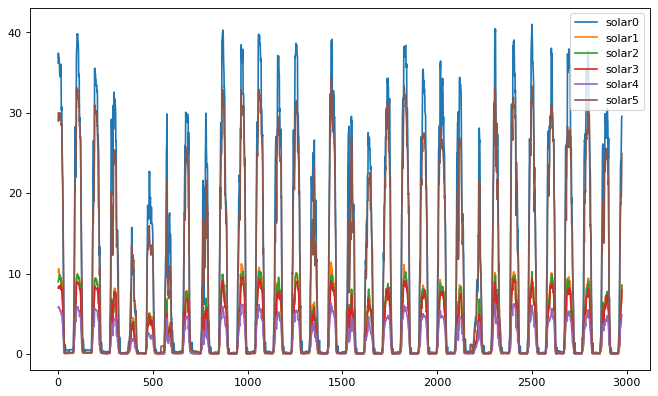

In [72]:
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(solar_models[0], label = 'solar0')
plt.plot(solar_models[1], label = 'solar1')
plt.plot(solar_models[2], label = 'solar2')
plt.plot(solar_models[3], label = 'solar3')
plt.plot(solar_models[4], label = 'solar4')
plt.plot(solar_models[5], label = 'solar5')
plt.legend()


In [68]:
accuracies

[0.91, 0.912, 0.912, 0.87, 0.912, 0.925]

In [71]:
accuracies

[0.915, 0.914, 0.927, 0.926, 0.918, 0.904]

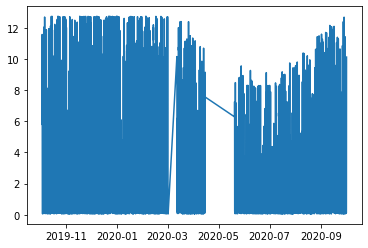

In [91]:
plt.plot(solar1['solar1'])
# plt.plot(solar0['solar0'])

In [90]:
solar0

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),solar0,hour,day
2020-05-21 05:15:00,12.1600,6.0500,4.6925,101791.2200,0.665,188.2975,318.7000,0.3975,1.05,05,0
2020-05-21 05:30:00,11.9700,5.9900,4.5550,101792.3500,0.670,173.7850,316.0100,0.4250,2.10,05,0
2020-05-21 05:45:00,11.7800,5.9300,4.4175,101793.4800,0.675,159.2725,313.3200,0.4525,1.89,05,0
2020-05-21 06:00:00,11.5900,5.8700,4.2800,101794.6100,0.680,144.7600,310.6300,0.4800,1.69,06,0
2020-05-21 06:15:00,11.4125,5.9250,4.2475,101810.4725,0.690,122.1000,310.0750,0.5050,1.08,06,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,11.8025,6.8275,5.0100,101674.3875,0.715,367.3475,282.5450,0.3100,29.67,22,0
2020-09-30 23:00:00,12.0600,6.8000,5.1000,101692.5000,0.700,406.3800,282.6900,0.3500,29.94,23,0
2020-09-30 23:15:00,12.2750,6.6775,5.0475,101699.9525,0.685,444.8525,282.1825,0.3825,34.02,23,0
2020-09-30 23:30:00,12.4900,6.5550,4.9950,101707.4050,0.670,483.3250,281.6750,0.4150,38.10,23,0


In [56]:
loaded_data,frequency,forecast_horizon,contain_missing_values,contain_equal_length=convert_tsf_to_dataframe('phase_2_data.tsf',replace_missing_vals_with="NaN",value_column_name="series_value")
loaded_data

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,"[283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606..."
1,Building1,2019-01-09 23:15:00,"[8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,..."
2,Building3,2016-03-01 04:15:00,"[1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293...."
3,Building4,2019-07-03 04:45:00,"[2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ..."
4,Building5,2019-07-25 23:00:00,"[30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33...."
5,Building6,2019-07-25 01:45:00,"[36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35...."
6,Solar0,2020-04-25 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Solar1,2018-12-31 13:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Solar2,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Solar3,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [57]:
loaded_data,frequency,forecast_horizon,contain_missing_values,contain_equal_length=convert_tsf_to_dataframe('nov_data.tsf',replace_missing_vals_with="NaN",value_column_name="series_value")
loaded_data

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,"[283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606..."
1,Building1,2019-01-09 23:15:00,"[8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,..."
2,Building3,2016-03-01 04:15:00,"[1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293...."
3,Building4,2019-07-03 04:45:00,"[2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ..."
4,Building5,2019-07-25 23:00:00,"[30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33...."
5,Building6,2019-07-25 01:45:00,"[36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35...."
6,Solar0,2020-04-25 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Solar1,2018-12-31 13:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Solar2,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Solar3,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [137]:
energy = pd.read_csv('October Energy Demand and Price.csv')

# energy['Date'] = pd.to_datetime(energy['SETTLEMENTDATE'])

energy.set_index('SETTLEMENTDATE', inplace=True)
energy = energy.drop(['REGION','PERIODTYPE'], axis=1)
energy = energy[500:550]
energy

,TOTALDEMAND,RRP
SETTLEMENTDATE,,
11/10/2020 10:30,3758.52,32.24
11/10/2020 11:00,3593.61,24.28
11/10/2020 11:30,3456.85,19.74
11/10/2020 12:00,3319.62,32.87
11/10/2020 12:30,3156.68,17.44
11/10/2020 13:00,3050.55,17.03
11/10/2020 13:30,2982.38,6.67
11/10/2020 14:00,2975.43,15.36
11/10/2020 14:30,3045.49,23.20


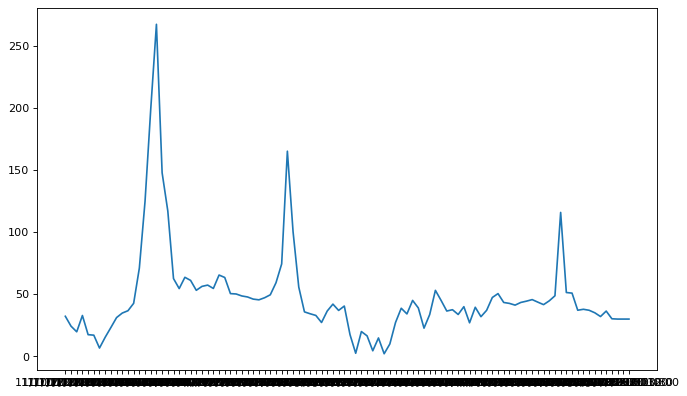

In [128]:
plt.figure(figsize=(10, 6), dpi=80)
# plt.plot(energy['TOTALDEMAND'], label='Demand')
plt.plot(energy['RRP'], label='Price')
# plt.legend()